<a href="https://colab.research.google.com/github/adnil8130/T5LittleGenQA/blob/main/T5%E7%94%9F%E6%88%90%E5%BC%8F%E9%97%AE%E7%AD%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 目标
训练一个生成式问答模型，base模型采用Google T5-Base("uer/t5-base-chinese-cluecorpussmall")

预训练模型地址：https://huggingface.co/uer/t5-base-chinese-cluecorpussmall

模型的评价指标采用BLEU-1，BLEU-2，BLEU-3，BLEU-4。

# 数据集
数据集：链接：https://pan.quark.cn/s/6d4a98cd65f2    

提取码：bzne

数据的格式如下：
```
{"context": "违规分为:一般违规扣分、严重违规扣分、出售假冒商品违规扣分,淘宝网每年12月31日24:00点会对符合条件的扣分做清零处理,详情如下:|温馨提醒:由于出售假冒商品24≤N<48分,当年的24分不清零,所以会存在第一年和第二年的不同计分情况。", "answer": "12月31日24:00", "question": "淘宝扣分什么时候清零", "id": 203}
```

# 1. 准备数据

In [67]:
# ! pip install transformers

In [108]:
import transformers
import numpy as np
import torch
print(transformers.__version__)
print(torch.__version__)
from torch.utils.data import Dataset, random_split
import json

4.49.0
2.5.1+cu124


In [69]:
max_context_len = 0
max_question_len = 0
max_answer_len = 0
context = ""
questiont = ""
answer = ""

context_len = []
question_len = []
answer_len = []

save_path_file = '.'
train_data_address = save_path_file + '/train.json'
dev_data_address = save_path_file + '/dev.json'

with open(train_data_address, 'rt', encoding='utf-8') as f:
  for idx, line in enumerate(f):
    sample = json.loads(line.strip())
    context_len.append(len(sample['context']))
    question_len.append(len(sample['question']))
    answer_len.append(len(sample['answer']))
    if len(sample["context"]) > max_context_len:
        max_context_len = len(sample["context"])
        context = sample["context"]
    if len(sample["question"]) > max_question_len:
        max_question_len = len(sample["question"])
        question = sample["question"]
    if len(sample["answer"]) > max_answer_len:
        max_answer_len = len(sample["answer"])
        answer = sample["answer"]

with open(dev_data_address, 'rt', encoding='utf-8') as f:
  for idx, line in enumerate(f):
    sample = json.loads(line.strip())
    context_len.append(len(sample['context']))
    question_len.append(len(sample['question']))
    answer_len.append(len(sample['answer']))
    if len(sample["context"]) > max_context_len:
        max_context_len = len(sample["context"])
        context = sample["context"]
    if len(sample["question"]) > max_question_len:
        max_question_len = len(sample["question"])
        question = sample["question"]
    if len(sample["answer"]) > max_answer_len:
        max_answer_len = len(sample["answer"])
        answer = sample["answer"]

print("最长context", max_context_len, context)
print("最长question", max_question_len, question)
print("最长answer", max_answer_len, answer)

最长context 1881 孩子几点睡觉最能长高个？现在很多家长已经意识到孩子的身高不完全是受父母遗传的因 素所决定，后天的饮食、锻炼、睡眠对身高的影响也很大。以往，饮 食是影响身高的最主要因素，而如今，学习负担造成了很多孩子的睡 眠不足，所以睡眠对身高也有着很大的影响。“生长激素”是影响人体身高的重要因素，而生长激素不像人体的其 他激素在白天分泌，它是呈脉冲式分泌，主要在晚上分泌，分泌得越 多，就越有助于长高。21：00-凌晨 1：00 是生长激素分泌高峰，一 旦晚睡错过了， 就再也补不回来了。 生长激素是由人的脑垂体分泌的， 脑垂体一天的工作量很大， 除了要分泌生长激素外， 还要分泌性激素、 促肾上腺皮质激素等人体所需的多种激素，也因为“太忙了”，所以 它并不是 24 小时都在分泌生长激素。婴儿期是个例外。婴儿期时，不管是白天还是晚上，脑垂体在不断地 分泌生长激素，所以 1 岁以前的婴儿，长得特别快。幼儿后，生长激 素在白天的分泌量就非常少了，分泌量主要集中在晚上入睡时。其中 有两个时间段对长高至关重要，一个是晚 9 点至第二天凌晨 1 点， 特别是晚上 10 点以后，生长激素的分泌量达到最高，可以达到白天 的 5-7 倍。另外，早上 6 点前后的一两个小时，生长激素也有一个 分泌小高峰。不过并不是一到晚上 9 点， 生长激素就开始按时大量分泌， 它的大量 分泌必须有个前提：只有在深度睡眠时才会发生。如果这个时间还没 上床，或者已经上床但还没睡着，又或者已经睡着但还没进入深睡眠状态，那么它的分泌量就会大大降低。所以睡得越迟，分泌的生长激 素就越少， 对孩子的身高越不利。 而人一般在入睡后半小时至 1 小时， 才进入深度睡眠状态， 所以生长发育专家的建议是： 想要孩子长得高， 最好在晚上 8：30 前就上床，最迟不要超过晚 9：30，早上 7 点以 后再起床。 不同年龄段的睡眠时间表 年龄段 适宜睡眠时间 新生儿 20-22 小时2 月婴儿 18-20 小时 1岁 2岁 3-4 岁 5-7 岁 8-12 岁 15 小时 14 小时 13 小时 12 小时 10 小时13-18 岁 9 小时另外，阳光中有大量的天然钙剂，因此在阳光充足的时候，要带着孩 子多参与户外活动。21：00-凌晨1：00？现在很多家长已经意识到孩子的身高不完全是受父母遗传的因 素所决定

In [70]:
import numpy as np

def print_mean_std(data):
    # 转换为 NumPy 数组
    arr = np.array(data)
    
    # 计算平均值
    mean = np.mean(arr)
    print("平均值:", mean)  # 输出: 3.0
    
    # 计算标准差
    std_dev = np.std(arr)                # 默认计算总体标准差 (ddof=0)
    sample_std_dev = np.std(arr, ddof=1) # 样本标准差 (ddof=1)
    
    print("总体标准差:", std_dev)        # 输出: 1.41421356
    print("样本标准差:", sample_std_dev)  # 输出: 1.58113883
    print("")

print_mean_std(context_len)
print_mean_std(question_len)
print_mean_std(answer_len)

平均值: 283.3061790505676
总体标准差: 193.44619621148513
样本标准差: 193.45243510320984

平均值: 9.270510835913313
总体标准差: 2.770987527086612
样本标准差: 2.771076895042615

平均值: 5.562113003095975
总体标准差: 4.073706442947103
样本标准差: 4.073837825284484



In [71]:
import matplotlib.pyplot as plt
from collections import Counter

def plt_hist(data):
    # 统计数字出现次数
    counter = Counter(data)
    numbers = list(counter.keys())    # 横轴数字
    counts = list(counter.values())  # 纵轴次数
    
    # 绘制条形图
    plt.figure(figsize=(8, 5))
    bars = plt.bar(numbers, counts, color='skyblue', edgecolor='black', width=0.8)
    
    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height,
                 f'{height}', ha='center', va='bottom')
    
    # 设置坐标轴和标题
    plt.xlabel("数字")
    plt.ylabel("出现次数")
    plt.title("数字出现次数统计图")
    plt.xticks(numbers)  # 确保横轴刻度为具体数字
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    plt.show()

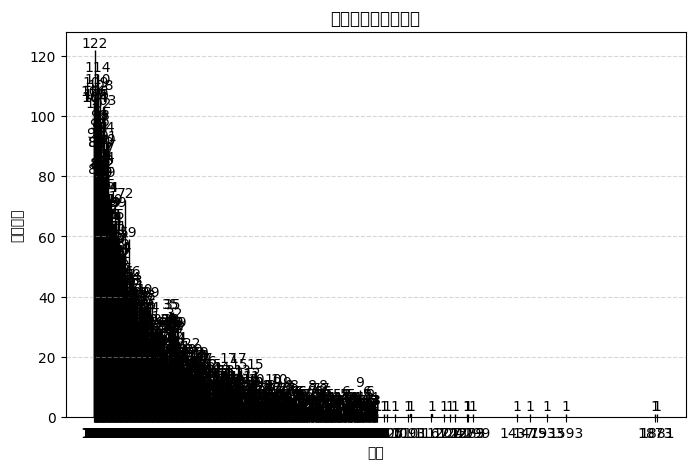

In [72]:
plt_hist(context_len)

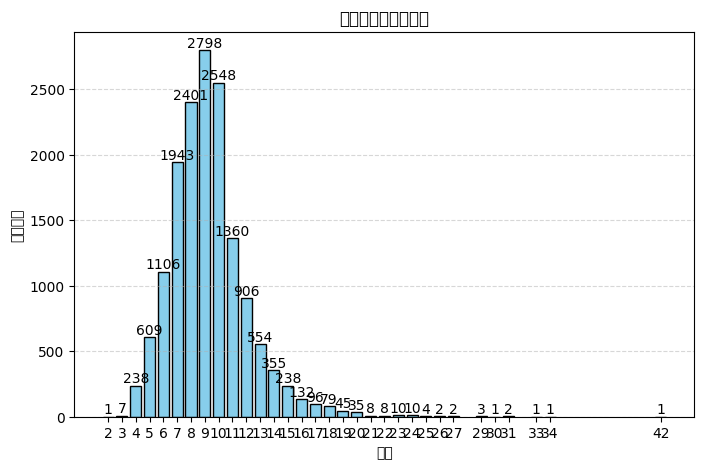

In [73]:
plt_hist(question_len)

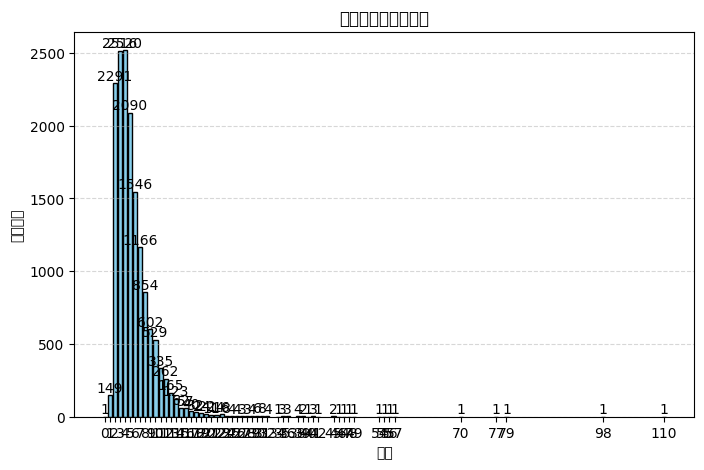

In [74]:
plt_hist(answer_len)

## 构建数据集

In [75]:
train_ratio = 0.9
max_dataset_size = 22000
train_set_size = 20000
valid_set_size = 2000

class GenQA(Dataset):
  def __init__(self, data_file):
    self.data = self.load_data(data_file)

  def load_data(self, data_file):
    Data = {}
    with open(data_file, 'rt', encoding='utf-8') as f:
      for idx, line in enumerate(f):
        if idx >= max_dataset_size:
            break
        sample = json.loads(line.strip())
        Data[idx] = sample
    return Data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

data = GenQA(train_data_address)
data_size = len(data)

train_size = int(train_ratio * data_size)
valid_size = data_size - train_size
train_data, valid_data = random_split(data, [train_size, valid_size])
test_data = GenQA(dev_data_address)

In [76]:
print(f'train set size: {len(train_data)}')
print(f'valid set size: {len(valid_data)}')
print(f'test set size: {len(test_data)}')
print(next(iter(train_data)))

train set size: 13068
valid set size: 1452
test set size: 984
{'context': 'HTML是超文本描述语言，也就是常见的静态网页的语言，一般用IE就可以打开。你说的打不开，其实是看不见里面的内容，这是因为简体的HTM文件在开头部分默认添加了一句language=GB2312，意思是说通知浏览器用编码GB2312也就是简体字来显示里面的内容，而繁体字用的是Big5码，所以你就看不见了。', 'answer': 'IE', 'question': 'html 用什么打开', 'id': 11592}


## 数据预处理

In [90]:
from transformers import AutoTokenizer
model_checkpoint = './t5-base-chinese-cluecorpussmall'
# model_checkpoint = 'uer/t5-small-chinese-cluecorpussmall'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,return_token_type_ids=False)

In [91]:
context = train_data[0]["context"]
question = train_data[0]["question"]
answer = train_data[0]["answer"]

inputs = tokenizer(context, question)
targets = tokenizer(answer)

In [92]:
print(tokenizer.convert_ids_to_tokens(inputs["input_ids"]))
print(tokenizer.convert_ids_to_tokens(targets["input_ids"]))

['[CLS]', '[UNK]', '是', '超', '文', '本', '描', '述', '语', '言', '，', '也', '就', '是', '常', '见', '的', '静', '态', '网', '页', '的', '语', '言', '，', '一', '般', '用', '[UNK]', '就', '可', '以', '打', '开', '。', '你', '说', '的', '打', '不', '开', '，', '其', '实', '是', '看', '不', '见', '里', '面', '的', '内', '容', '，', '这', '是', '因', '为', '简', '体', '的', '[UNK]', '文', '件', '在', '开', '头', '部', '分', '默', '认', '添', '加', '了', '一', '句', 'language', '=', '[UNK]', '，', '意', '思', '是', '说', '通', '知', '浏', '览', '器', '用', '编', '码', '[UNK]', '也', '就', '是', '简', '体', '字', '来', '显', '示', '里', '面', '的', '内', '容', '，', '而', '繁', '体', '字', '用', '的', '是', '[UNK]', '码', '，', '所', '以', '你', '就', '看', '不', '见', '了', '。', '[SEP]', 'html', '用', '什', '么', '打', '开', '[SEP]']
['[CLS]', '[UNK]', '[SEP]']


In [93]:
import torch

max_input_length = 512
max_target_length = 32
sample_cnt = 4

inputs = [train_data[s_idx]["context"] + train_data[s_idx]["question"] + "?" for s_idx in range(sample_cnt)]
targets = [train_data[s_idx]["answer"] for s_idx in range(sample_cnt)]

model_inputs = tokenizer(
    inputs,
    padding=True,
    max_length=max_input_length,
    truncation=True,
    return_tensors="pt",
    return_token_type_ids=False
)
labels = tokenizer(
    text_target=targets,
    padding=True,
    max_length=max_target_length,
    truncation=True,
    return_tensors="pt",
    return_token_type_ids=False
)["input_ids"]

end_token_index = torch.where(labels == 102)[-1]
for idx, end_idx in enumerate(end_token_index):
    labels[idx][end_idx+1:] = -100

print('batch_X shape:', {k: v.shape for k, v in model_inputs.items()})
print('batch_y shape:', labels.shape)
print(model_inputs)
print(labels)

batch_X shape: {'input_ids': torch.Size([4, 135]), 'attention_mask': torch.Size([4, 135])}
batch_y shape: torch.Size([4, 8])
{'input_ids': tensor([[ 101,  100, 3221, 6631, 3152, 3315, 2989, 6835, 6427, 6241, 8024,  738,
         2218, 3221, 2382, 6224, 4638, 7474, 2578, 5381, 7552, 4638, 6427, 6241,
         8024,  671, 5663, 4500,  100, 2218, 1377,  809, 2802, 2458,  511,  872,
         6432, 4638, 2802,  679, 2458, 8024, 1071, 2141, 3221, 4692,  679, 6224,
         7027, 7481, 4638, 1079, 2159, 8024, 6821, 3221, 1728,  711, 5042,  860,
         4638,  100, 3152,  816, 1762, 2458, 1928, 6956, 1146, 7949, 6371, 3924,
         1217,  749,  671, 1368, 8348,  134,  100, 8024, 2692, 2590, 3221, 6432,
         6858, 4761, 3846, 6229, 1690, 4500, 5356, 4772,  100,  738, 2218, 3221,
         5042,  860, 2099, 3341, 3227, 4850, 7027, 7481, 4638, 1079, 2159, 8024,
         5445, 5246,  860, 2099, 4500, 4638, 3221,  100, 4772, 8024, 2792,  809,
          872, 2218, 4692,  679, 6224,  749,  511, 

In [94]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForSeq2SeqLM
import gc

train_batch_size = 32
test_batch_size = 64

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

def clean_cuda(device):
    if device == 'cuda':
        # 清理无用变量
        gc.collect()
        torch.cuda.empty_cache()

clean_cuda(device)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
model = model.to(device)

def collote_fn(batch_samples):
    batch_inputs, batch_targets = [], []
    for sample in batch_samples:
        batch_inputs.append(sample["context"] + sample["question"] + "?")
        batch_targets.append(sample['answer'])
    batch_data = tokenizer(
        batch_inputs,
        text_target=batch_targets,
        padding=True,
        max_length=max_input_length,
        truncation=True,
        return_tensors="pt",
        return_token_type_ids=False
    )

    # with tokenizer.as_target_tokenizer():
    #     labels = tokenizer(
    #         batch_targets,
    #         padding=True,
    #         max_length=max_target_length,
    #         truncation=True,
    #         return_tensors="pt"
    #     )["input_ids"]

    batch_data['decoder_input_ids'] = model.prepare_decoder_input_ids_from_labels(batch_data['labels'])
    end_token_index = torch.where(batch_data['labels'] == 102)[-1]
    for idx, end_idx in enumerate(end_token_index):
        batch_data['labels'][idx][end_idx+1:] = -100
    return batch_data

train_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True, collate_fn=collote_fn)
valid_dataloader = DataLoader(valid_data, batch_size=test_batch_size, shuffle=False, collate_fn=collote_fn)

Using cuda device


In [95]:
batch = next(iter(train_dataloader))
print(batch.keys())
print('batch shape:', {k: v.shape for k, v in batch.items()})
print(batch)

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])
batch shape: {'input_ids': torch.Size([32, 512]), 'attention_mask': torch.Size([32, 512]), 'labels': torch.Size([32, 47]), 'decoder_input_ids': torch.Size([32, 47])}
{'input_ids': tensor([[ 101, 6006, 6432,  ..., 7027, 4638,  102],
        [ 101,  704, 1744,  ...,  671, 4013,  102],
        [ 101, 2769, 3300,  ...,    0,    0,    0],
        ...,
        [ 101,  100, 3152,  ...,    0,    0,    0],
        [ 101,  872, 1377,  ..., 4374, 3308,  102],
        [ 101, 1921,  671,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[ 101, 4904, 1921,  ..., -100, -100, -100],
        [ 101,  704, 1744,  ..., -100, -100, -100],
        [ 101, 6043, 6963,  ..., -100, -100, -100],
        ...,
   

# 2. 模型训练

## 优化模型参数

In [96]:
from tqdm.auto import tqdm
import random

def train_loop(dataloader, model, optimizer, lr_scheduler, epoch, total_loss):
    progress_bar = tqdm(range(len(dataloader)))
    progress_bar.set_description(f'loss: {0:>7f}')
    finish_batch_num = (epoch-1) * len(dataloader)

    model.train()
    loss_record_step = []
    for batch, batch_data in enumerate(dataloader, start=1):
        batch_data = batch_data.to(device)
        outputs = model(**batch_data)

        random_number = random.uniform(0, 1)

        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        loss_record_step.append(loss.item())
        progress_bar.set_description(f'loss: {total_loss/(finish_batch_num + batch):>7f}')
        progress_bar.update(1)
        del batch_data, outputs, loss
        clean_cuda(device)
    return total_loss, loss_record_step

## 评估指标

In [97]:
# ! pip install sacrebleu

In [98]:
from sacrebleu.metrics import BLEU

predictions = [
    "This plugin lets you translate web pages between several languages automatically."
]
bad_predictions_1 = ["This This This This"]
bad_predictions_2 = ["This plugin"]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]

bleu1 = BLEU(max_ngram_order=1)
print("==========BLEU-1==========")
print(bleu1.corpus_score(predictions, references).score)
print(bleu1.corpus_score(bad_predictions_1, references).score)
print(bleu1.corpus_score(bad_predictions_2, references).score)

bleu2 = BLEU(max_ngram_order=2)
print("==========BLEU-2==========")
print(bleu2.corpus_score(predictions, references).score)
print(bleu2.corpus_score(bad_predictions_1, references).score)
print(bleu2.corpus_score(bad_predictions_2, references).score)

bleu3 = BLEU(max_ngram_order=3)
print("==========BLEU-3==========")
print(bleu3.corpus_score(predictions, references).score)
print(bleu3.corpus_score(bad_predictions_1, references).score)
print(bleu3.corpus_score(bad_predictions_2, references).score)

bleu4 = BLEU(max_ngram_order=4)
print("==========BLEU-4==========")
print(bleu4.corpus_score(predictions, references).score)
print(bleu4.corpus_score(bad_predictions_1, references).score)
print(bleu4.corpus_score(bad_predictions_2, references).score)

==========BLEU-1==========
84.33740467435464
2.634980614046608
0.40867714384640685
==========BLEU-2==========
65.05696445772017
2.1514526621798953
0.40867714384640685
==========BLEU-3==========
53.804523766396294
1.8269935164445736
0.0
==========BLEU-4==========
46.750469682990186
1.683602693167689
0.0


In [99]:
import random

def test_loop(dataloader, model, sample_ovserve_ratio=0.05):
    preds, labels = [], []

    model.eval()
    for batch_data in tqdm(dataloader):
        batch_data = batch_data.to(device)
        with torch.no_grad():
            generated_tokens = model.generate(
                batch_data["input_ids"],
                attention_mask=batch_data["attention_mask"],
                max_length=max_target_length,
            ).cpu().numpy()
        label_tokens = batch_data["labels"].cpu().numpy()

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

        random_number = random.uniform(0, 1)
        if random_number < sample_ovserve_ratio:
            print("input:", tokenizer.batch_decode(batch_data["input_ids"].cpu().numpy(), skip_special_tokens=True))
            print("output:", decoded_preds)

        label_tokens = np.where(label_tokens != -100, label_tokens, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(label_tokens, skip_special_tokens=True)

        del batch_data
        clean_cuda(device)

        preds += [pred.strip() for pred in decoded_preds]
        labels += [[label.strip()] for label in decoded_labels]
    return bleu1.corpus_score(preds, labels).score, bleu2.corpus_score(preds, labels).score, bleu3.corpus_score(preds, labels).score, bleu4.corpus_score(preds, labels).score

## 保存模型

In [100]:
# test_data = GenQA(dev_data_address)
# test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False, collate_fn=collote_fn)

# test_loop(test_dataloader, model)

In [101]:
import matplotlib.pyplot as plt
import numpy as np

def save_data_and_plot(data, txt_file_path, img_file_path):
    # ===================== 写入文件部分 =====================
    # 追加写入数据（自动创建文件）
    with open(txt_file_path, 'a') as f:
        # 将数字转为字符串并换行写入
        f.write('\n'.join(map(str, data)))
        f.write('\n')  # 添加换行符分隔不同写入批次

    # ===================== 读取文件部分 =====================
    # 从文件读取所有数字
    loaded_data = []
    try:
        with open(txt_file_path, 'r') as f:
            for line in f:
                # 去除空白字符并尝试转换为浮点数
                cleaned_line = line.strip()
                if cleaned_line:
                    loaded_data.append(float(cleaned_line))
    except FileNotFoundError:
        print("错误：文件不存在")
        exit()

    # ===================== 绘图部分 =====================
    plt.figure(figsize=(10, 6))
    plt.plot(loaded_data,
            color='green',
            linestyle='--',
            marker='s',
            markersize=8,
            linewidth=2)

    # 图表装饰
    plt.title("数值变化曲线", fontsize=14, pad=20)
    plt.xlabel("数据索引", fontsize=12, labelpad=10)
    plt.ylabel("测量值", fontsize=12, labelpad=10)
    plt.grid(True, alpha=0.4, linestyle=':')

    # 自动调整坐标轴范围
    plt.xlim(0, len(loaded_data)-1)
    plt.ylim(min(loaded_data)-1, max(loaded_data)+1)

    # 保存和显示
    plt.savefig(img_file_path, dpi=300, bbox_inches='tight')
    plt.close()  # 关闭图表释放内存

    print("操作结果：")
    print(f"- 数据已保存至 {txt_file_path}")
    print(f"- 生成曲线图：{img_file_path}")
    print(f"- 加载数据量：{len(loaded_data)} 条")

In [106]:
clean_cuda(device)

In [ ]:
from transformers import AdamW, get_scheduler

learning_rate = 2e-5
epoch_num = 31

optimizer = AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=epoch_num*len(train_dataloader),
)

total_loss = 0.
best_bleu1 = 0.
best_bleu2 = 0.
best_bleu3 = 0.
best_bleu4 = 0.
best_bleu_weighted_add = 0.
txt_file_path = save_path_file + '/lossdata.txt'
img_file_path = save_path_file + '/lossdata.png'
model_parm_path = None

train_batch_size = 16
test_batch_size = 32

train_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True, collate_fn=collote_fn)
valid_dataloader = DataLoader(valid_data, batch_size=test_batch_size, shuffle=False, collate_fn=collote_fn)

if model_parm_path is not None:
    model.load_state_dict(torch.load(model_parm_path))

for t in range(epoch_num):
    clean_cuda(device)
    print(f"Epoch {t+1}/{epoch_num}\n-------------------------------")

    # 查看清理后剩余显存
    print(f"可用显存: {torch.cuda.mem_get_info()[0]/1024**3:.2f} GB")

    total_loss, loss_record_step = train_loop(train_dataloader, model, optimizer, lr_scheduler, t+1, total_loss)
    save_data_and_plot(loss_record_step, txt_file_path, img_file_path)

    # 查看清理后剩余显存
    print(f"可用显存: {torch.cuda.mem_get_info()[0]/1024**3:.2f} GB")
    valid_bleu1, valid_bleu2, valid_bleu3, valid_bleu4 = test_loop(valid_dataloader, model)
    print(f"BLEU1: {valid_bleu1:>0.2f}\n")
    if valid_bleu1 > best_bleu1:
        best_bleu1 = valid_bleu1
    print(f"BLEU2: {valid_bleu2:>0.2f}\n")
    if valid_bleu2 > best_bleu2:
        best_bleu2 = valid_bleu2
    print(f"BLEU3: {valid_bleu3:>0.2f}\n")
    if valid_bleu3 > best_bleu3:
        best_bleu3 = valid_bleu3
    print(f"BLEU4: {valid_bleu4:>0.2f}\n")
    if valid_bleu4 > best_bleu4:
        best_bleu4 = valid_bleu4

    valid_bleu = 0.1 * valid_bleu1 + 0.2 * valid_bleu2 + 0.3 * valid_bleu3 + 0.4 * valid_bleu4
    if valid_bleu > best_bleu_weighted_add or t % 5 == 0:
        best_bleu_weighted_add = valid_bleu
        print('saving new weights...\n')
        torch.save(model.state_dict(), save_path_file + f'/epoch_{t+1}_loss_{loss_record_step[-1]:0.7f}_valid_bleu_{valid_bleu:0.2f}_model_weights.bin')
print("Done!")

Epoch 1/31
-------------------------------
可用显存: 18.77 GB


  0%|          | 0/817 [00:00<?, ?it/s]

/tmp/ipykernel_1183/1171673335.py:46: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.savefig(img_file_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_1183/1171673335.py:46: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.savefig(img_file_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_1183/1171673335.py:46: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.savefig(img_file_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_1183/1171673335.py:46: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.savefig(img_file_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_1183/1171673335.py:46: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from font(s) DejaVu Sans.
  plt.savefig(img_file_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_1183/1171673335.py:46: UserWarning: Glyp

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：817 条
可用显存: 14.56 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['目 前 国 内 的 不 可 以 了 。 日 前, 中 国 最 大 三 家 比 特 币 交 易 平 台, 比 特 币 中 国 、 火 币 网 、 币 行 发 布 公 告, 宣 布 升 级 反 洗 钱 系 统, 全 面 暂 停 比 特 币 、 莱 特 币 的 提 现 业 务 。 没 错, 这 意 味 着 中 国 大 规 模 洗 钱 通 道 正 式 崩 塌! 现 在 你 能 从 平 台 拿 走 的 只 有 人 民 币, 平 台 内 外 都 能 追 踪 。 虽 然 宣 布 的 只 是 暂 停 提 现, 但 是 如 果 找 不 到 解 决 办 法, 不 排 除 将 无 限 期 延 长 。 比 特 币 什 么 时 候 能 提 现?', '正 常 天 天 需 要 的 热 卡 数 量 一 般 在 2000 至 3500 卡 之 间 ， 计 算 起 来 比 较 麻 烦 。 您 假 如 想 要 算 的 话 ， 可 以 买 本 营 养 学 的 工 具 书 参 考 一 下 。 具 体 算 法 大 致 是 这 样 的 ： 第 一 步 ， 统 计 你 一 天 中 参 加 各 种 活 动 的 时 间 ， 比 如 ： 睡 眠 、 走 路 、 脑 力 工 作 、 体 力 工 作 （ 含 工 作 强 度 ） 等 等 ， 分 得 很 细 的 ， 记 录 每 项 活 动 多 长 时 间 。 第 二 步 ， 查 表 ， 根 据 每 项 活 动 平 均 消 耗 的 热 卡 数 和 每 项 活 动 的 时 间 ， 还 要 结 合 你 自 己 的 体 重 、 年 龄 等 因 素 ， 最 后 计 算 出 天 天 消 耗 的 热 卡 值 。 第 三 步 ， 查 表 ， 按 照 每 种 食 物 所 含 单 位 热 卡 值 制 定 食 谱 ， 使 天 天 摄 入 的 热 卡 数 与 天 天 消 耗 的 热 卡 数 平 衡 ， 就 可 以 保 证 不 增 减 体 重 ； 假 如 要 减 肥 ， 那 就 要 在 此 基 础 上 减 少 。 举 例 来 说 ， 假 如 天 天 进 食 的 热 卡 比 消 耗 的 热 卡 少 900 卡 （ 当 然 这 减 少 得 比 较 大 ， 只 是 为 了 计 算 方 便 ） ， 那 就 意 味 着 这 900 卡 热 量 缺 口 要 通 过 消 耗 你 身 上 的 脂 

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：1634 条
可用显存: 14.40 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['哪 种 延 时 药 物 比 较 好 ？ 议 用 中 医 治 疗 ， 可 以 用 一 些 外 用 的 延 时 药 比 较 好 ， 口 服 的 不 建 议 使 用 的 7. 问 候 你 我 的 朋 友 ： 送 你 阳 光 ， 替 你 把 痛 苦 蒸 发 ， 送 你 细 雨 ， 替 你 把 龌 龊 冲 刷 。 送 你 流 星 ， 替 你 带 走 噩 梦 ， 你 开 心 了 吧 ！ | 首 先 试 试 诺 瑞 吗 ， 其 次 减 轻 自 己 的 心 理 以 及 工 作 压 力 ， 然 后 加 强 体 质 锻 炼 ， 没 有 解 决 不 了 的 问 题 的 。 | 你 可 以 尝 试 控 制 节 奏 ， 需 要 多 锻 炼 ， 增 加 锻 炼 ， 耐 下 心 ， 辅 助 喷 点 艾 力 久 ， 效 果 会 更 好 点 的 。 | " 如 果 觉 得 自 己 不 够 持 久 的 话 ， 建 议 喷 爱 力 久 ， 以 及 多 加 强 锻 炼 身 体 ， 注 意 作 息 时 间 ， ， 体 质 好 了 ， 当 然 就 更 持 久 ， 活 也 就 好 了 。 " | 所 以 首 先 要 加 强 身 体 方 面 的 锻 炼 ， 然 后 多 吃 一 些 壮 阳 类 的 食 物 ， 像 山 药 ， 动 物 的 肝 脏 ， 韭 菜 等 等 ， 不 够 的 话 ， 再 喷 点 诺 锐 玛 ， 时 间 相 对 会 延 长 一 段 时 间 的 。 什 么 延 时 药 效 果 好?', '《 明 天 你 好 》 是 由 华 语 组 合 牛 奶 咖 啡 演 唱 的 一 首 励 志 歌 曲 。 由 王 海 涛 作 词 、 牛 奶 咖 啡 作 曲 、 格 非 编 曲 ， 歌 曲 曲 调 柔 美 ， 略 带 感 伤 。 收 录 在 其 2011 年 发 行 的 《 去 寻 找 》 中 。 歌 词 ： 看 昨 天 的 我 们 走 远 了 在 命 运 广 场 中 央 等 待 那 模 糊 的 肩 膀 越 奔 跑 越 渺 小 曾 经 并 肩 往 前 的 伙 伴 在 举 杯 祝 福 后 都 走 散 只 是 那 个 夜 晚 我 深 深 的 都 留 藏 在 心 坎 长 大 以 后 我 只 能 奔 跑 我 多 害 怕 黑 暗 中 跌 倒 明 天 你 好 含 着 泪 微 笑 越 美 好 越 害 怕 得 到

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：2451 条
可用显存: 14.95 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['内 蒙 古 人 事 考 试 信 息 网 消 息 : 2017 年 内 蒙 古 公 务 员 考 试 笔 试 4 月 22 日 结 束, 很 多 考 生 关 注 2017 年 内 蒙 古 公 公 务 员 考 试 笔 试 成 绩 查 询 时 间, 据 悉, 2017 年 内 蒙 古 公 务 员 成 绩 时 间 预 计 5 月 中 旬, 届 时, 华 图 教 育 将 及 时 开 通 2017 年 内 蒙 古 公 务 员 成 绩 查 询 入 口 。 内 蒙 古 公 务 员 成 绩 查 询 时 间?', '这 个 字 是 琛 ， 读 音 是 。 【 汉 字 】 ： 琛 【 读 音 】 ： 【 部 首 】 ： 王 【 笔 画 】 ： 12 【 词 组 】 ： 琛 瑞 、 & # 8205 ; 琛 、 & # 8205 ; 琛 板 、 & # 8205 ; 琛 帛 、 & # 8205 ; 琛 丽 、 & # 8205 ; 琛 、 & # 8205 ; 琛 、 & # 8205 ; 海 琛 、 & # 8205 ; 琛 献 、 & # 8205 ; 隋 琛 、 & # 8205 ; 国 琛 、 & # 8205 ; 琛 、 & # 8205 ; 琛 、 & # 8205 ; 琛 册 、 & # 8205 ; 遐 琛 、 & # 8205 ; 琛 贡 、 & # 8205 ; 贡 琛 、 & # 8205 ; 灵 琛 、 & # 8205 ; 天 琛 、 & # 8205 ; 献 琛 、 & # 8205 ; 琛 、 & # 8205 ; 琛 琲 、 & # 8205 ; 琛 贝 、 & # 8205 ; 琛 币 、 & # 8205 ; 山 琛 & # 8205 ; & # 8205 ; 。 深 去 掉 三 点 水 加 王?', '提 起 人 民 币 ， 没 有 人 不 喜 欢 它 ， 当 然 是 越 多 越 好 。 一 堆 人 民 币 放 在 那 里 ， 看 着 都 觉 得 养 眼 。 | 说 实 话 ， 笔 者 也 不 知 道 ， 为 此 ， 小 编 特 意 查 找 了 一 下 ， 大 家 可 以 根 据 每 张 100 元 的 重 量 计 算 出 来 。 | 一 张 刚 出 库 的 百 元 大 钞 大 约 重 1. 15 克 ， 一 吨 换 算 成 单 位 

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：3268 条
可用显存: 14.60 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['一 般 可 以 用 千 若 轩 藓 达 净 治 疗 ， 期 间 忌 辛 辣 酒 饮 食 ， 避 免 过 热 水 洗 泡 ， 忌 用 肥 皂 ， 加 强 卫 生 。 | 在 有 手 足 癣 疾 病 时 候 。 属 于 真 菌 感 染 引 起 。 需 要 对 症 的 使 用 藓 达 净 软 膏 涂 抹 治 疗 为 宜 ， 避 免 服 用 辛 辣 食 物 为 宜 意 见 建 议 ： 建 议 注 意 保 持 足 部 的 干 燥 为 宜 。 积 极 对 症 治 疗 为 宜 手 癣 用 什 么 药 膏 效 果 好?', '北 京 有 大 大 小 小 五 个 机 场 。 如 下 : 1 、 北 京 首 都 国 际 机 场 地 址 : 北 京 市 顺 义 区 机 场 南 路 。 2 、 北 京 南 苑 机 场 地 址 : 北 京 市 丰 台 区 南 苑 南 四 环 警 备 东 路 。 3 、 北 京 平 谷 金 海 湖 机 场 地 址 : 北 京 市 平 谷 区 近 郊 胡 黑 路 。 4 、 密 云 机 场 地 址 : 北 京 市 密 云 区 双 沙 路 附 近 。 5 、 定 陵 机 场 北 京 市 昌 平 区 定 陵 路 口 西 200 米 。 北 京 几 个 机 场?', '以 学 生 为 中 心 的 教 学 理 念 : 教 材 遵 循 以 学 生 为 中 心 的 整 体 式 语 言 教 学 理 念, 强 调 语 言 学 习 应 该 在 自 然 、 真 实 、 完 整 的 语 言 情 境 中 进 行, 鼓 励 学 习 者 在 做 中 学 、 学 中 用 。 教 材 巧 妙 地 创 设 了 多 种 真 实 的 交 际 情 景, 倡 导 任 务 型 教 学 活 动, 通 过 大 量 有 意 义 的 语 言 技 能 练 习 调 动 学 习 者 的 兴 趣 和 动 力, 培 养 他 们 用 英 语 思 维 的 习 惯 和 综 合 运 用 英 语 的 能 力 以 兴 趣 为 驱 动, 提 高 听 说 读 写 综 合 技 能 : 教 材 的 编 排 体 现 了 话 题 、 功 能 和 单 项 技 能 训 练 的 紧 密 结 合, 强 调 语 言 的 实 际 功 能 运 用, 也 就 是 用 英 语 听 说 和 做 事 的 能 力, 符 合 中 国 老 师 和 学 员 

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：4085 条
可用显存: 14.19 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['据 了 解, 在 e 租 宝 平 台 关 闭 前, 平 台 账 户 还 有 100 多 亿 。 按 照 最 低 额 度 计 算, 现 在 e 租 宝 账 户 上 至 少 有 200 亿 可 以 返 还 。 根 据 最 高 人 民 检 察 院 数 据 显 示, e 租 宝 投 资 人 累 计 充 值 581. 75 亿 元 。 如 果 不 计 算 已 经 提 现 的 数 额, 依 据 该 数 字 现 在 e 租 宝 受 害 人 可 以 返 还 的 比 例 大 概 为 33. 44 % 。 e 租 宝 最 新 进 展 返 还 比 例?', '在 北 京 、 上 海, 贷 款 400 多 万 买 一 套 房, 你 要 付 387 万 的 利 息 成 本, 而 在 新 加 坡, 同 样 的 贷 款 金 额, 你 只 要 付 60 万 的 利 息 成 本 。 在 此 瑞 投 咨 网 邀 投 资 者 去 新 加 坡 看 房, 贷 款 利 息 很 便 宜 。 价 格 跟 一 线 城 市 高 档 公 寓 差 不 多 新 加 坡 可 供 海 外 置 业 者 购 买 的 房 屋 ( 私 人 住 宅 ) 大 部 分 价 格 在 7 万 ~ 20 万 元 / ㎡ 不 等, 这 与 一 线 城 市 的 高 档 公 寓 价 格 相 差 无 几 。 北 京 二 环 以 内 高 档 公 寓 均 价 普 遍 过 10 万 元 / ㎡ ; 上 海 浦 东 区 域 的 高 档 公 寓 也 超 过 了 12 万 元 / ㎡ 。 作 为 以 华 人 为 主 体 的 热 带 国 家, 突 出 的 教 育 优 势 、 治 安 环 境 等 因 素, 也 成 为 置 业 新 加 坡 的 重 要 原 因 。 狮 城 楼 市 : 中 国 成 最 大 外 籍 投 资 客 瑞 投 咨 网 相 关 人 士 介 绍 说, 过 去 10 年 里, 新 加 坡 私 人 住 宅 的 房 价 维 持 每 年 10 % ~ 15 % 的 涨 幅, 虽 然 投 资 回 报 率 相 对 国 内 偏 低, 但 相 对 其 他 地 方 的 房 价 仍 具 备 优 势 。 相 关 数 据 显 示, 在 购 买 新 加 坡 私 人 住 宅 的 高 端 物 业 成 交 数 据 新 加 坡 房 价 多 少 钱 一 平?', '淋 巴 

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：4902 条
可用显存: 13.58 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['一 般 可 以 用 千 若 轩 藓 达 净 治 疗 ， 期 间 忌 辛 辣 酒 饮 食 ， 避 免 过 热 水 洗 泡 ， 忌 用 肥 皂 ， 加 强 卫 生 。 | 在 有 手 足 癣 疾 病 时 候 。 属 于 真 菌 感 染 引 起 。 需 要 对 症 的 使 用 藓 达 净 软 膏 涂 抹 治 疗 为 宜 ， 避 免 服 用 辛 辣 食 物 为 宜 意 见 建 议 ： 建 议 注 意 保 持 足 部 的 干 燥 为 宜 。 积 极 对 症 治 疗 为 宜 手 癣 用 什 么 药 膏 效 果 好?', '北 京 有 大 大 小 小 五 个 机 场 。 如 下 : 1 、 北 京 首 都 国 际 机 场 地 址 : 北 京 市 顺 义 区 机 场 南 路 。 2 、 北 京 南 苑 机 场 地 址 : 北 京 市 丰 台 区 南 苑 南 四 环 警 备 东 路 。 3 、 北 京 平 谷 金 海 湖 机 场 地 址 : 北 京 市 平 谷 区 近 郊 胡 黑 路 。 4 、 密 云 机 场 地 址 : 北 京 市 密 云 区 双 沙 路 附 近 。 5 、 定 陵 机 场 北 京 市 昌 平 区 定 陵 路 口 西 200 米 。 北 京 几 个 机 场?', '以 学 生 为 中 心 的 教 学 理 念 : 教 材 遵 循 以 学 生 为 中 心 的 整 体 式 语 言 教 学 理 念, 强 调 语 言 学 习 应 该 在 自 然 、 真 实 、 完 整 的 语 言 情 境 中 进 行, 鼓 励 学 习 者 在 做 中 学 、 学 中 用 。 教 材 巧 妙 地 创 设 了 多 种 真 实 的 交 际 情 景, 倡 导 任 务 型 教 学 活 动, 通 过 大 量 有 意 义 的 语 言 技 能 练 习 调 动 学 习 者 的 兴 趣 和 动 力, 培 养 他 们 用 英 语 思 维 的 习 惯 和 综 合 运 用 英 语 的 能 力 以 兴 趣 为 驱 动, 提 高 听 说 读 写 综 合 技 能 : 教 材 的 编 排 体 现 了 话 题 、 功 能 和 单 项 技 能 训 练 的 紧 密 结 合, 强 调 语 言 的 实 际 功 能 运 用, 也 就 是 用 英 语 听 说 和 做 事 的 能 力, 符 合 中 国 老 师 和 学 员 

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：5719 条
可用显存: 13.03 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['重 庆 朝 天 门 医 院 是 一 所 集 医 疗 、 预 防 、 保 健 、 康 复 、 科 研 和 教 学 为 一 体 的 现 代 化 腋 臭 医 院 ， 医 院 一 直 以 解 除 患 者 疾 病 为 己 任 ， 以 特 色 诊 疗 技 术 和 高 尖 端 的 设 备 为 标 准 ， 以 精 湛 医 术 和 优 质 的 服 务 获 得 患 者 的 良 好 口 碑 。 | 医 院 凝 聚 高 水 平 、 高 学 历 、 经 验 丰 富 的 腋 臭 科 人 才 梯 队 ， 传 承 千 年 中 医 精 髓 ， 同 时 及 时 开 展 国 际 前 沿 技 术 成 果 的 临 床 应 用 ， 实 现 了 科 研 及 临 床 诊 治 水 平 的 跨 越 式 发 展 ， 为 山 城 人 民 皮 肤 健 康 事 业 发 展 助 力 ！ 重 庆 去 狐 臭 手 术 哪 里 好?', '应 该 是 初 级 的 抗 氧 化 吧 我 觉 得 如 果 皮 肤 底 子 好 一 些 的 话 大 概 25 岁 左 右 使 用 如 果 皮 肤 比 较 差 一 些 的 话 可 能 早 一 些 使 用 也 可 以 哦 最 好 是 搭 配 一 个 系 列 的 使 用 还 有 不 要 忘 记 防 晒 霜 哦 | 男 士 净 肤 细 致 2 件 套 男 士 用 这 个 好, 另 外 多 带 4 盒 面 膜, 多 补 水, 肌 肤 就 逐 渐 提 升 健 康 以 及 水 润 舒 服 。 喜 欢 我 的 回 答 就 手 下 留 情, 一 个 好 评 就 够 了 ╮ ( ╯3╰ ) ╭ 碧 欧 泉 男 士 哪 个 系 列 好?', '上 海 浦 东 机 场 去 香 港 飞 行 时 间 两 个 小 时, 飞 机 起 飞 才 可 以 算. 现 在 香 港 比 较 繁 忙, 往 往 是 机 舱 关 门 后, 你 还 要 等 航 空 管 理 局 通 知 起 飞 时 间. 如 果 你 朋 友 在 香 港 接 你 的 话, 你 告 诉 他 们, 你 的 ( 航 班 号 ) 就 行 了. 然 后 我 还 要 指 出 一 点, 飞 机 起 飞 的 英 文 是 ( 离 港 / 起 飞 ). 着 陆 是, 到 达 是. 你 告 诉 你 的 朋 友 在 香 港 看 机 场 的 指 示 牌 就 知 道 你 的 行 

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：6536 条
可用显存: 13.56 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['你 好 ， 现 代 已 知 的 同 位 素 共 有 十 五 种 ， 有 碳 8 至 碳 22 ， 其 中 碳 12 和 碳 13 属 稳 定 型 ， 其 余 的 均 带 放 射 性 ， 当 中 碳 14 的 半 衰 期 长 达 5730 年 ， 其 他 的 为 稳 定 同 位 素 。 在 地 球 的 自 然 界 里 ， 碳 12 在 所 有 碳 的 含 量 占 98. 93 % ， 碳 13 则 有 1. 07 % 。 的 原 子 量 取 碳 12 、 13 两 种 同 位 素 丰 度 加 权 的 平 均 值 ， 一 般 计 算 时 取 12. 01 。 碳 12 是 国 际 单 位 制 中 定 义 摩 尔 的 尺 度 ， 以 12 克 碳 12 中 含 有 的 原 子 数 为 1 摩 尔 。 碳 14 由 于 具 有 较 长 的 半 衰 期 ， 衰 变 方 式 为 β 衰 变 ， 碳 14 原 子 转 变 为 氮 原 子 且 碳 是 有 机 物 的 元 素 之 一 ， 生 物 在 生 存 的 时 候 ， 由 于 需 要 呼 吸 ， 其 体 内 的 碳 14 含 量 大 致 不 变 ， 生 物 死 去 后 会 停 止 呼 吸 ， 此 时 体 内 的 碳 14 开 始 减 少 。 人 们 可 透 过 倾 测 一 件 古 物 的 碳 14 含 量 ， 来 估 计 它 的 大 概 年 龄 ， 这 种 方 法 称 之 为 碳 定 年 法 。 碳 有 几 种 同 位 素?', '英 国 本 科 留 学 费 用 ： 学 费 1 、 国 内 的 学 生 去 英 国 读 书 ， 绝 大 多 数 的 学 校 的 学 费 还 必 须 得 全 额 缴 纳 。 而 且 一 些 学 校 对 于 留 学 生 的 奖 学 金 申 请 要 求 也 非 常 的 高 ， 对 本 地 的 学 生 要 求 就 非 常 低 了 。 2 、 英 国 大 多 数 的 学 校 的 收 费 标 准 都 是 学 校 自 己 设 定 的 ， 没 有 一 个 具 体 的 标 准 ， 所 以 一 些 的 学 校 学 费 价 格 就 参 差 不 齐 。 但 是 收 费 标 准 还 是 有 一 些 的 规 律 的 ， 一 般 学 校 排 名 越 高 、 地 理 位 置 约 靠 近 大 城 市 的 学 费 就 

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：7353 条
可用显存: 13.38 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['《 》 是 挪 威 电 子 音 乐 制 作 人 艾 伦 · 沃 克 制 作 、 挪 威 女 歌 手 艾 斯 琳 · 索 尔 海 姆 演 唱 的 一 首 歌 曲 ， 为 其 2014 年 纯 电 音 作 品 《 》 的 改 编 版 。 词 曲 由 杰 斯 珀 · 伯 根 、 艾 伦 · 沃 克 、 以 及 创 作 完 成 。 歌 曲 于 2015 年 11 月 25 日 以 单 曲 形 式 发 行 。 2016 年 2 月 11 日 ， 艾 伦 · 沃 克 推 出 了 歌 曲 的 弦 乐 版 本 。 alan walker 女 声 是 谁?', '通 常 是 这 样 的 ， 排 卵 这 天 精 卵 在 输 卵 管 的 壶 腹 部 受 精 ， 然 后 在 三 到 五 天 内 ， 逐 渐 移 行 至 子 宫 腔 内 ， 游 离 几 天 后 ， 选 择 好 最 佳 着 床 位 置 ， 然 后 扎 根 ， 继 续 妊 娠 。 这 个 着 床 时 间 大 约 是 排 卵 后 的 7 到 10 天 ； 着 床 后 ， 有 的 人 会 有 早 孕 反 应 出 现 ， 每 个 人 表 现 不 一 样 ； 如 果 排 卵 时 机 掌 握 恰 当 ， 处 理 后 ， 最 早 10 天 就 有 可 能 测 出 是 否 怀 孕 。 个 别 人 因 体 内 激 素 分 泌 差 异 ， 可 能 得 晚 些 时 间 才 能 测 出 。 先 用 早 早 孕 试 纸 测 测 看 ， 或 者 去 医 院 检 查 血 β - 通 常 认 为 只 要 是 阳 性 结 果 就 有 可 能 怀 孕 了 ， 检 验 值 超 过 5 就 能 肯 定 ( 请 注 意 ： 是 查 血 β - ， 这 个 灵 敏 度 高 ， 可 以 很 早 就 发 现 是 否 怀 孕 ！ 而 不 是 查 血 ， 这 个 灵 敏 度 相 对 较 低 ； 妊 娠 不 同 时 期 以 及 各 孕 妇 之 间 血 清 绝 对 值 变 化 很 大 ， 每 个 人 与 别 人 是 不 相 同 的 ， 没 有 可 比 性 ， 只 可 自 身 比 较 。 ) 祝 您 好 孕 ！ 受 精 几 天 能 测 出 来?', '熔 点 300 沸 点 300 水 溶 性 差 密 度 5 - 40 外 观 无 色 无 味 、 白 色 或 者 米 

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：8170 条
可用显存: 13.81 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['我 现 在 温 室 种 远 古, 春 季 种 草 莓, 夏 季 蓝 莓, 秋 季 蔓 越 莓 。 我 想 问 问 这 几 样 作 物 是 酿 酒 卖 得 贵 还 是 做 果 酱 卖 得 贵 。 我 现 在 只 知 道 蓝 莓 酿 酒 比 果 酱 贵, 其 他 的 求 老 司 机 告 知 | 酒 的 价 格 是 水 果 的 价 格, 果 酱 的 价 格 是 水 果 的 价 格 + 50, 酿 酒 要 七 天, 做 果 酱 要 两 天 。 利 与 弊 自 己 衡 量 。 | 有 人 算 过, 利 润 最 高 的 酿 酒 是 远 古, 其 次 杨 桃, 和 远 古 相 差 不 多, 草 莓 蓝 莓 蔓 越 梅 跟 前 面 那 俩 差 的 挺 多 | 讲 真 的, 如 果 是 第 二 年 就 别 钟 什 么 蓝 莓 蔓 越 莓, 毕 竟 第 二 年 酿 造 桶 起 来 了, 钟 蓝 莓 蔓 越 莓 酿 不 值 钱, | 走 酿 造 的 话 春 季 外 面 种 大 黄, 夏 季 星 星 果, 秋 季 南 瓜 或 者 甜 瓜, 这 几 样 我 专 门 看 过, 都 是 那 一 季 度 最 高 酿 造 价 格 ( 种 这 些 的 前 提 是 你 远 古 种 不 多, 不 够 铺 外 面 ) | 泡 吧 蓝 莓 跟 蔓 越 莓, 一 个 不 到 100, 翻 三 倍 也 是 泡 吧, 而 且 同 样 也 是 要 酿 7 天, 不 如 种 基 础 价 值 高 的 | 一 个 蓝 莓 50 金, 三 倍 150, 要 酿 7 天, 我 买 沙 漠 蜂 蜜 都 比 你 酿 这 个 赚 钱 多 蜂 蜜 一 天 就 好, 一 个 赚 80 七 天 赚 560 星 露 谷 物 语 酿 酒 时 间?', '王 者 荣 耀 每 个 赛 季 的 时 间 为 期 3 个 月 左 右, 腾 讯 一 般 是 在 最 后 时 间 段 才 会 公 布 具 体 日 期 的, 不 过 依 照 之 前 几 个 赛 季 的 结 束 时 间 来 推 算, s7 赛 季 是 在 4 月 初 开 始 的, 而 s8 赛 季 也 是 在 6 月 底 开 启, 按 照 3 个 月 的 时 间 来 推 算 的 话, s8 赛 季 将 会 在 7 月 底 8 月 初 的 时 间 结 束, 想 要 上 分 的 小 

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：8987 条
可用显存: 14.19 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['一 般 可 以 用 千 若 轩 藓 达 净 治 疗 ， 期 间 忌 辛 辣 酒 饮 食 ， 避 免 过 热 水 洗 泡 ， 忌 用 肥 皂 ， 加 强 卫 生 。 | 在 有 手 足 癣 疾 病 时 候 。 属 于 真 菌 感 染 引 起 。 需 要 对 症 的 使 用 藓 达 净 软 膏 涂 抹 治 疗 为 宜 ， 避 免 服 用 辛 辣 食 物 为 宜 意 见 建 议 ： 建 议 注 意 保 持 足 部 的 干 燥 为 宜 。 积 极 对 症 治 疗 为 宜 手 癣 用 什 么 药 膏 效 果 好?', '北 京 有 大 大 小 小 五 个 机 场 。 如 下 : 1 、 北 京 首 都 国 际 机 场 地 址 : 北 京 市 顺 义 区 机 场 南 路 。 2 、 北 京 南 苑 机 场 地 址 : 北 京 市 丰 台 区 南 苑 南 四 环 警 备 东 路 。 3 、 北 京 平 谷 金 海 湖 机 场 地 址 : 北 京 市 平 谷 区 近 郊 胡 黑 路 。 4 、 密 云 机 场 地 址 : 北 京 市 密 云 区 双 沙 路 附 近 。 5 、 定 陵 机 场 北 京 市 昌 平 区 定 陵 路 口 西 200 米 。 北 京 几 个 机 场?', '以 学 生 为 中 心 的 教 学 理 念 : 教 材 遵 循 以 学 生 为 中 心 的 整 体 式 语 言 教 学 理 念, 强 调 语 言 学 习 应 该 在 自 然 、 真 实 、 完 整 的 语 言 情 境 中 进 行, 鼓 励 学 习 者 在 做 中 学 、 学 中 用 。 教 材 巧 妙 地 创 设 了 多 种 真 实 的 交 际 情 景, 倡 导 任 务 型 教 学 活 动, 通 过 大 量 有 意 义 的 语 言 技 能 练 习 调 动 学 习 者 的 兴 趣 和 动 力, 培 养 他 们 用 英 语 思 维 的 习 惯 和 综 合 运 用 英 语 的 能 力 以 兴 趣 为 驱 动, 提 高 听 说 读 写 综 合 技 能 : 教 材 的 编 排 体 现 了 话 题 、 功 能 和 单 项 技 能 训 练 的 紧 密 结 合, 强 调 语 言 的 实 际 功 能 运 用, 也 就 是 用 英 语 听 说 和 做 事 的 能 力, 符 合 中 国 老 师 和 学 员 

  0%|          | 0/817 [00:00<?, ?it/s]

In [111]:
test_data = GenQA(dev_data_address)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False, collate_fn=collote_fn)

import json

model.load_state_dict(torch.load('./epoch_16_loss_4.4422817_valid_bleu_0.00_model_weights.bin'))

model.eval()
with torch.no_grad():
    print('evaluating on test set...')
    sources, preds, labels = [], [], []
    for batch_data in tqdm(test_dataloader):
        batch_data = batch_data.to(device)
        generated_tokens = model.generate(
            batch_data["input_ids"],
            attention_mask=batch_data["attention_mask"],
            max_length=max_target_length,
        ).cpu().numpy()
        label_tokens = batch_data["labels"].cpu().numpy()

        decoded_sources = tokenizer.batch_decode(
            batch_data["input_ids"].cpu().numpy(),
            skip_special_tokens=True,
            use_source_tokenizer=True
        )
        # print('decoded_sources', decoded_sources)

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        # print('decoded_preds', decoded_preds)
        label_tokens = np.where(label_tokens != -100, label_tokens, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(label_tokens, skip_special_tokens=True)
        # print('decoded_labels', decoded_labels)

        sources += [source.strip() for source in decoded_sources]
        preds += [pred.strip() for pred in decoded_preds]
        labels += [[label.strip()] for label in decoded_labels]
    bleu_score = bleu4.corpus_score(preds, labels).score
    print(f"Test BLEU: {bleu_score:>0.2f}\n")
    results = []
    print('saving predicted results...')
    for source, pred, label in zip(sources, preds, labels):
        results.append({
            "sentence": source,
            "prediction": pred,
            "translation": label[0]
        })
    with open('test_data_pred.json', 'wt', encoding='utf-8') as f:
        for exapmle_result in results:
            f.write(json.dumps(exapmle_result, ensure_ascii=False) + '\n')

/tmp/ipykernel_1183/1186398811.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./epoch_16_loss_4.4422817_valid_bleu_0.00_model_weights.

evaluating on test set...


  0%|          | 0/31 [00:00<?, ?it/s]

Test BLEU: 0.00

saving predicted results...


In [110]:
model.load_state_dict(torch.load('./epoch_16_loss_4.4422817_valid_bleu_0.00_model_weights.bin'))
test_dataloader1 = DataLoader(test_data, batch_size=1, shuffle=False, collate_fn=collote_fn)
test_loop(test_dataloader1, model, sample_ovserve_ratio=1)


/tmp/ipykernel_1183/3357543093.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./epoch_16_loss_4.4422817_valid_bleu_0.00_model_weights.

  0%|          | 0/984 [00:00<?, ?it/s]

input: ['年 基 准 利 率 4. 35 % 。 从 实 际 看, 贷 款 的 基 本 条 件 是 : 一 是 中 国 大 陆 居 民, 年 龄 在 60 岁 以 下 ; 二 是 有 稳 定 的 住 址 和 工 作 或 经 营 地 点 ; 三 是 有 稳 定 的 收 入 来 源 ; 四 是 无 不 良 信 用 记 录, 贷 款 用 途 不 能 作 为 炒 股, 赌 博 等 行 为 ; 五 是 具 有 完 全 民 事 行 为 能 力 。 2017 年 银 行 贷 款 基 准 利 率?']
output: ['']
input: ['年 基 准 利 率 4. 35 % 。 从 实 际 看, 贷 款 的 基 本 条 件 是 : 一 是 中 国 大 陆 居 民, 年 龄 在 60 岁 以 下 ; 二 是 有 稳 定 的 住 址 和 工 作 或 经 营 地 点 ; 三 是 有 稳 定 的 收 入 来 源 ; 四 是 无 不 良 信 用 记 录, 贷 款 用 途 不 能 作 为 炒 股, 赌 博 等 行 为 ; 五 是 具 有 完 全 民 事 行 为 能 力 。 2017 年 银 行 贷 款 基 准 利 率?']
output: ['']
input: ['系 列 是 最 好 的 ， 采 用 国 际 顶 尖 技 术 （ 由 格 力 自 主 研 发 ） 双 级 变 频 压 缩 机 ， 提 高 压 缩 机 运 转 效 率 ， 制 冷 制 热 能 力 更 强 劲 ； 1 赫 兹 变 频 技 术 ， 使 空 调 相 当 于 一 个 15 电 灯 泡 ， 更 加 节 能 省 电 ； 送 风 面 积 广 ， 风 力 大 ； 生 态 风 ， 净 化 空 气 。 非 常 不 错 ， 现 在 国 美 在 做 活 动 ， 可 以 了 解 一 下 。 格 力 空 调 哪 个 系 列 好?']
output: ['']
input: ['平 面 操 作 区 域 进 深 （ 即 宽 度 ） 以 40 至 60 厘 米 为 宜 ； 要 充 分 考 虑 洗 菜 盆 的 宽 度 。 以 标 准 洗 菜 盆 来 算 ， 应 选 择 550 － － 的 宽 度 为 好 。 另 ： 在 高 度 方 面 ， 根 据 我 国 人 体 高 度 测 算 ， 掌 握 以 下 尺 寸 为 宜 ： 操 作 台 高 度 在

KeyboardInterrupt: 